### Parameter setup

In [23]:
import os
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

evname = "S0976a_pzfiltered"
dtype = "DISP"

# PP and SS arrival time
# # S1000a
# PP_arrival_time = UTCDateTime("2021-09-18T18:01:48.4") # MQS: 2021-09-18T18:01:47
# SS_arrival_time = UTCDateTime("2021-09-18T18:14:04.5") # MQS: 2021-09-18T18:14:08
# S0976a
PP_arrival_time = UTCDateTime("2021-08-25T03:49:13")
SS_arrival_time = UTCDateTime("2021-08-25T04:03:16")

cutwin = (-100, 100) # for plotting only, does not trim data

datadir = os.path.join(filedir, "misc", evname)

### Load sac files and define time vectors

In [24]:
# Load rotated traces
st_z = read(os.path.join(datadir, f"{evname}_{dtype}_BHZ.SAC"))[0]
st_r = read(os.path.join(datadir, f"{evname}_{dtype}_BHR.SAC"))[0]
st_t = read(os.path.join(datadir, f"{evname}_{dtype}_BHT.SAC"))[0]

# Get trace start time
start_time = st_z.stats.starttime

# Zoom windows
z_time_center = PP_arrival_time - start_time
t_time_center = SS_arrival_time - start_time

# Time arrays
t_z = st_z.times()
t_r = st_r.times()
t_t = st_t.times()

# Indices for zooming
idx_z = (t_z >= z_time_center + cutwin[0]) & (t_z <= z_time_center + cutwin[1])
idx_r = (t_r >= t_time_center + cutwin[0]) & (t_r <= t_time_center + cutwin[1])
idx_t = (t_t >= t_time_center + cutwin[0]) & (t_t <= t_time_center + cutwin[1])

### Plot to confirm

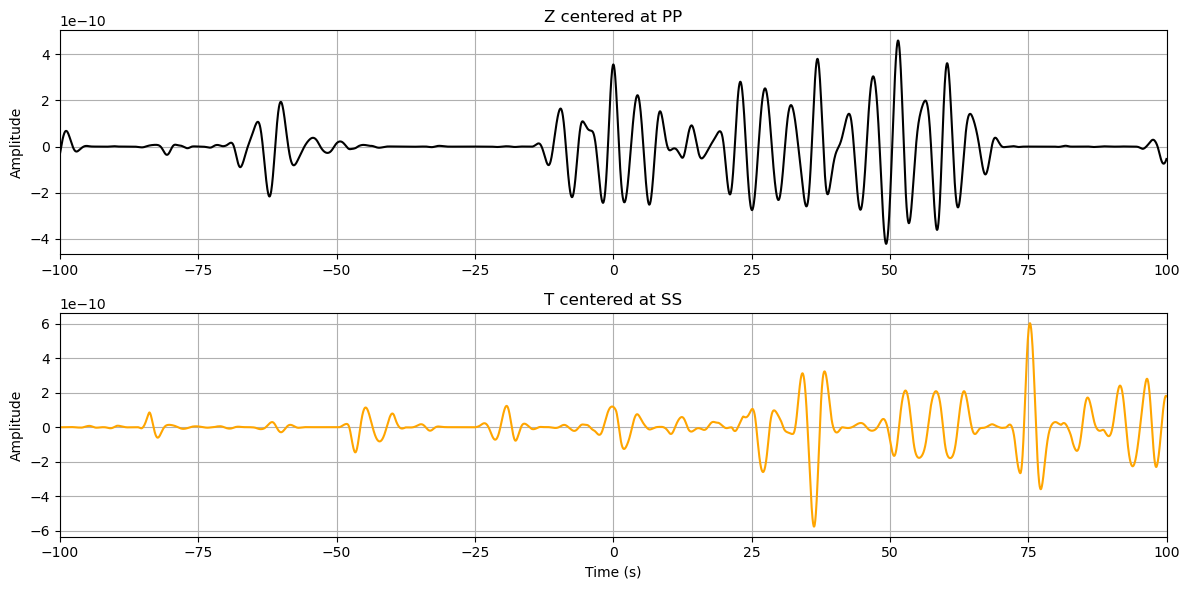

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_z[idx_z]-z_time_center, st_z.data[idx_z], color='black')
plt.xlim(cutwin)
plt.title("Z centered at PP")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_t[idx_t]-t_time_center, st_t.data[idx_t], color='orange')
plt.xlim(cutwin)
plt.title("T centered at SS")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

### Getting reference wavelet

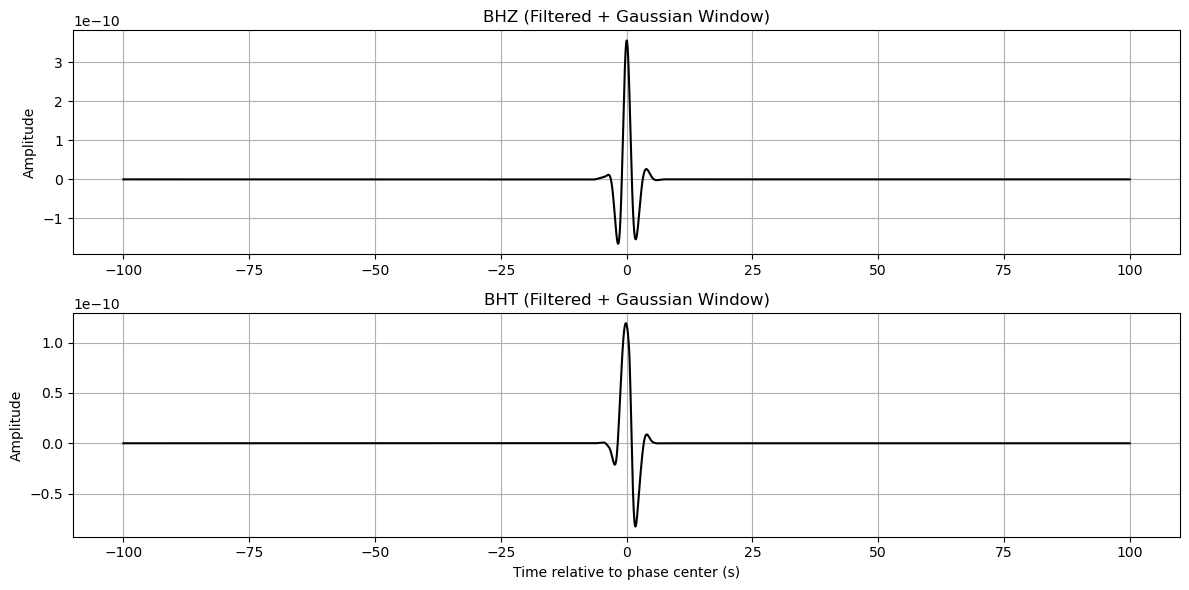

In [26]:
import numpy as np
# --- Apply Gaussian Window ---

# Zoomed times relative to center
t_zoom_z = t_z[idx_z] - z_time_center
t_zoom_t = t_t[idx_t] - t_time_center

# Gaussian window
sigma = 2.0
gaussian_window_z = np.exp(-0.5 * (t_zoom_z / sigma)**2)
gaussian_window_t = np.exp(-0.5 * (t_zoom_t / sigma)**2)

# Apply window to seismograms
z_filtered_windowed = st_z.data[idx_z] * gaussian_window_z
t_filtered_windowed = st_t.data[idx_t] * gaussian_window_t

# Plot windowed waveforms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_zoom_z, z_filtered_windowed, color='black')
plt.title("BHZ (Filtered + Gaussian Window)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_zoom_t, t_filtered_windowed, color='black')
plt.title("BHT (Filtered + Gaussian Window)")
plt.xlabel("Time relative to phase center (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

### Save

In [27]:
# Save name
save_suffix = "_src2s"

# Define cut window (in seconds)
# This will TRIM the data
cut_b, cut_a = -40, 40
cut_len = cut_a - cut_b

# Time vector centered at zero
time = np.arange(cut_b, cut_a, st_z.stats.delta)
npts_cut = len(time)

# Cut D: filtered data centered around phase arrival
idx_cut_z = (t_z >= z_time_center + cut_b) & (t_z < z_time_center + cut_a)
idx_cut_t = (t_t >= t_time_center + cut_b) & (t_t < t_time_center + cut_a)

D_z = st_z.data[idx_cut_z]
D_t = st_t.data[idx_cut_t]

# Ensure correct length for D
if len(D_z) != npts_cut:
    D_z = np.pad(D_z, (0, npts_cut - len(D_z)))
if len(D_t) != npts_cut:
    D_t = np.pad(D_t, (0, npts_cut - len(D_t)))

# Cut P
idx_cut_z = (t_zoom_z >= cut_b) & (t_zoom_z < cut_a)
idx_cut_t = (t_zoom_t >= cut_b) & (t_zoom_t < cut_a)
P_z = z_filtered_windowed[idx_cut_z]
P_t = t_filtered_windowed[idx_cut_t]

# Normalize
norm_z = max(np.abs(P_z))
P_z = P_z / norm_z
D_z = D_z / norm_z
norm_t = max(np.abs(P_t))
P_t = P_t / norm_t
D_t = D_t / norm_t

# Define output dirs
outdir_PP = os.path.join(filedir, "data", evname + save_suffix + "_PP")
outdir_SS = os.path.join(filedir, "data", evname + save_suffix + "_SS")

# Make directories if they don't exist
os.makedirs(outdir_PP, exist_ok=True)
os.makedirs(outdir_SS, exist_ok=True)

# Save .npz files
np.savez(os.path.join(outdir_PP, "data.npz"), P=P_z, D=D_z, time=time)
np.savez(os.path.join(outdir_SS, "data.npz"), P=P_t, D=D_t, time=time)